# 1. PROJE ÖDEVİ - BLG-407 MAKİNE ÖĞRENMESİ

**Adınız:** Mustafa Erdem

**Soyadınız:** Kaya

**Okul Numaranız:** 2212721009

**GitHub Repo Bağlantısı:** `https://github.com/kullanici_adi/CNN_siniflandirma`


# Model 3: Hiperparametre Optimizasyonu ve Veri Artırma

Bu bölümde, Model 2'nin performansı artırılmaya çalışılacaktır. Ödev gereksinimleri doğrultusunda aşağıdaki iyileştirmeler yapılmıştır:

## Amaç

Model 2'yi geliştirerek daha iyi performans elde etmek. Bu, hiperparametre optimizasyonu ve veri artırma teknikleri ile gerçekleştirilecektir.

## Yapılan İyileştirmeler

1. **Veri Artırma (Data Augmentation):** Eğitim setine rastgele döndürme, kaydırma, zoom ve çevirme işlemleri uygulanarak veri çeşitliliği artırılmıştır. Bu, modelin genelleme yeteneğini artırır.

2. **Mimari Değişikliği:**
   - Filtre sayıları artırılmış (32 → 64, 64 → 128)
   - Ekstra bir Conv2D bloğu eklendi
   - **Dropout (0.5)** katmanı eklenerek aşırı öğrenme (overfitting) engellenmiştir

3. **Hiperparametreler:**
   - Öğrenme oranı (Learning Rate) **0.001'den 0.0005'e** düşürülmüştür (daha yavaş ama kararlı öğrenme)
   - Epoch sayısı artırılmıştır (veri artırma nedeniyle daha fazla epoch gerekir)

## Model 2 ile Karşılaştırma

Model 2'de sadece normalizasyon yapılmış ve basit bir mimari kullanılmıştı. Model 3'te:
- Veri artırma ile daha fazla çeşitlilik
- Daha derin ve geniş mimari
- Dropout ile overfitting önleme
- Optimize edilmiş hiperparametreler

Bu değişikliklerin Model 2'ye göre performans artışı sağlaması beklenmektedir.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import os
from google.colab import drive
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Drive Bağlantısı
drive.mount('/content/drive')

# --- Temel Ayarlar ---
dataset_path = '/content/drive/MyDrive/makine öğrenmesi/ödev1/dataset'
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Adım 2.2: Online Veri Artırma (Data Augmentation)

Modelin genelleme yeteneğini artırmak için `ImageDataGenerator` parametreleri güncellenmiştir. Veri artırma, küçük veri setlerinde model performansını önemli ölçüde artırır.

## Veri Artırma Teknikleri:

* **`rotation_range=20`:** Görseller rastgele ±20 derece döndürülür. Bu, nesnenin farklı açılardan görünmesini sağlar.
* **`width_shift_range=0.1`:** Görseller %10 oranında yatay kaydırılır.
* **`height_shift_range=0.1`:** Görseller %10 oranında dikey kaydırılır.
* **`zoom_range=0.1`:** Görsellere %10 oranında zoom uygulanır.
* **`horizontal_flip=True`:** Görseller yatay olarak aynalanır (çok etkili bir teknik).
* **`vertical_flip=True`:** Görseller dikey olarak aynalanır (nesne yukarı/aşağı bakabilir).
* **`fill_mode='nearest'`:** Dönüşüm sonrası boş kalan alanlar en yakın piksel değeri ile doldurulur.

## Önemli Not:

Veri artırma işlemi **sadece eğitim (training)** setine uygulanır. Doğrulama (validation) seti orijinal haliyle bırakılır (sadece rescale yapılır). Bu, modelin gerçek performansını doğru ölçmemizi sağlar.

In [ ]:
# Eğitim verileri için veri artırma ile ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Piksel değerlerini 0-1 aralığına normalize et
    rotation_range=20,           # ±20 derece rastgele döndürme
    width_shift_range=0.1,       # %10 yatay kaydırma
    height_shift_range=0.1,      # %10 dikey kaydırma
    zoom_range=0.1,              # %10 zoom
    horizontal_flip=True,        # Yatay aynalama (çok etkili)
    vertical_flip=True,          # Dikey aynalama
    fill_mode='nearest'          # Boş alanları en yakın piksel ile doldur
)

# Doğrulama Verisi için SADECE Normalizasyon (Augmentation YOK)
# Doğrulama setinde veri artırma yapılmaz, böylece gerçek performans ölçülür
test_datagen = ImageDataGenerator(
    rescale=1./255,              # Sadece normalizasyon
    validation_split=0.2         # Veri setinin %20'sini doğrulama için ayır
)

print("Eğitim verileri (Artırılmış) yükleniyor...")
# Eğitim verileri için generator (veri artırma ile)
train_generator = train_datagen.flow_from_directory(
    dataset_path,                    # Veri setinin bulunduğu klasör
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Tüm görselleri 128x128 boyutuna getir
    batch_size=BATCH_SIZE,           # Her seferinde 32 görsel işle
    class_mode='binary',             # İkili sınıflandırma modu
    subset='training'                # Eğitim alt kümesini kullan (%80)
)

print("Doğrulama verileri (Orijinal) yükleniyor...")
# Doğrulama verileri için generator (veri artırma olmadan)
val_generator = test_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'             # Doğrulama alt kümesini kullan (%20)
)

print(f"Algılanan sınıflar: {train_generator.class_indices}")

Eğitim verileri (Artırılmış) yükleniyor...
Found 200 images belonging to 2 classes.
Doğrulama verileri (Orijinal) yükleniyor...
Found 40 images belonging to 2 classes.
Algılanan sınıflar: {'Kesici_Delici': 0, 'Taşıyıcı_Servis': 1}


# Adım 2.1: Model Mimarisinin Geliştirilmesi ve Hiperparametre Optimizasyonu

Model 2'ye göre yapılan değişiklikler ve gerekçeleri:

## Mimari Değişiklikleri:

1. **Filtre Sayısı Artırıldı:**
   - İlk katman: 32 → **64 filtre** (daha fazla özellik öğrenir)
   - İkinci ve üçüncü katmanlar: 64 → **128 filtre** (daha karmaşık özellikler)

2. **Ekstra Katman Eklendi:**
   - 3. bir Conv2D bloğu eklendi (daha derin mimari)
   - Bu, modelin daha karmaşık özellikler öğrenmesini sağlar

3. **Dropout Katmanı Eklendi:**
   - `layers.Dropout(0.5)` eklenerek nöronların %50'si rastgele kapatıldı
   - Bu, overfitting'i önler ve modelin genelleme yeteneğini artırır
   - Özellikle veri artırma ile birlikte çok etkilidir

## Hiperparametre Değişiklikleri:

4. **Öğrenme Oranı (Learning Rate) Düşürüldü:**
   - Model 2: 0.001 (varsayılan)
   - Model 3: **0.0005** (daha yavaş ama kararlı öğrenme)
   - Veri artırma kullanıldığında daha düşük learning rate genellikle daha iyi sonuç verir

5. **Epoch Sayısı Artırıldı:**
   - Model 2: 15 epoch
   - Model 3: 50 epoch (veri artırma nedeniyle daha fazla epoch gerekir)

## Beklenen Etkiler:

- **Daha derin mimari:** Daha karmaşık özellikler öğrenir
- **Daha fazla filtre:** Daha detaylı özellik çıkarımı
- **Dropout:** Overfitting'i önler
- **Düşük learning rate:** Daha kararlı ve iyi öğrenme
- **Veri artırma:** Genelleme yeteneğini artırır

In [ ]:
# Geliştirilmiş CNN modelini oluştur
model = models.Sequential([
    # 1. Evrişim Bloğu: 64 filtre ile temel özellikleri öğren (Model 2'de 32 idi)
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D((2, 2)),  # Boyutu yarıya indir (128x128 -> 64x64)

    # 2. Evrişim Bloğu: 128 filtre ile orta seviye özellikleri öğren (Model 2'de 64 idi)
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),  # Boyutu yarıya indir (64x64 -> 32x32)

    # 3. Evrişim Bloğu: 128 filtre ile yüksek seviye özellikleri öğren (YENİ EKLENEN)
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),  # Boyutu yarıya indir (32x32 -> 16x16)

    # Sınıflandırma Bloğu
    layers.Flatten(),              # Çok boyutlu veriyi düzleştir

    # DROPOUT EKLENDİ: Overfitting'i önlemek için %50 dropout
    layers.Dropout(0.5),           # Nöronların %50'sini rastgele kapat

    layers.Dense(128, activation='relu'),  # 128 nöronlu gizli katman (Model 2'de 64 idi)
    layers.Dense(1, activation='sigmoid')  # Çıkış katmanı (ikili sınıflandırma)
])

# Learning Rate Özelleştirme: Daha düşük learning rate ile kararlı öğrenme
opt = optimizers.Adam(learning_rate=0.0005)  # Model 2'de 0.001 (varsayılan) idi

# Modeli derle: Özelleştirilmiş Adam optimizer ve binary crossentropy loss ile
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()  # Model mimarisini görüntüle

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,434,753 (13.10 MB)

 Trainable params: 3,434,753 (13.10 MB)

 Non-trainable params: 0 (0.00 B)

# Modelin Eğitimi

Bu aşamada geliştirilmiş model eğitilmeye başlanır. Veri artırma kullanıldığı için öğrenme süreci daha zor olacaktır, bu nedenle daha fazla epoch gerekir.

## Eğitim Parametreleri:

* **`epochs=50`**: Veri artırma kullanıldığı için daha fazla epoch gerekir. Model 2'de 15 epoch kullanılmıştı.

* **`model.fit()`**: Eğitimi başlatan asıl fonksiyondur. Veri artırma sayesinde her epoch'ta farklı varyasyonlar görülecektir.

* **`train_generator`**: Veri artırma ile zenginleştirilmiş eğitim verilerini sağlar.

* **`validation_data=val_generator`**: Her epoch'ta orijinal doğrulama verileriyle test edilir.

## ModelCheckpoint ve Callback'ler:

* **ModelCheckpoint**: En iyi ağırlıkları otomatik kaydeder
* **ReduceLROnPlateau**: Validation loss düşmediğinde learning rate'i azaltır
* **EarlyStopping**: Overfitting'i önlemek için erken durdurma (isteğe bağlı)

**Not**: Veri artırma nedeniyle eğitim süresi daha uzun olacaktır, ancak model genelleme yeteneği artacaktır.

In [ ]:
# ModelCheckpoint: En iyi ağırlıkları kaydet
checkpointer = ModelCheckpoint(
    filepath='model3_best_weights.weights.h5',
    monitor='val_accuracy',              # Validation accuracy'i izle
    verbose=1,                       # Kayıt işlemini göster
    save_best_only=True,            # Sadece en iyi modeli kaydet
    save_weights_only=True          # Sadece ağırlıkları kaydet
)


print("Gelişmiş Model Eğitimi Başlıyor (Veri Artırma + Hiperparametre Optimizasyonu)...")
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[checkpointer],  # En iyi ağırlıkları kaydet
    verbose=1
)

Gelişmiş Model Eğitimi Başlıyor (Veri Artırma + Hiperparametre Optimizasyonu)...
Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8392 - loss: 0.3671
Epoch 1: val_accuracy improved from -inf to 0.85000, saving model to model3_best_weights.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - accuracy: 0.8374 - loss: 0.3705 - val_accuracy: 0.8500 - val_loss: 0.3277
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.8178 - loss: 0.3819
Epoch 2: val_accuracy improved from 0.85000 to 0.87500, saving model to model3_best_weights.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.8212 - loss: 0.3816 - val_accuracy: 0.8750 - val_loss: 0.3675
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.8208 - loss: 0.3774
Epoch 3: val_accuracy did not improve from 0.87500
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step - accuracy: 0.8219 - loss: 0.3791 - val_accuracy: 0.8750 - val_loss: 0.3187
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.7670

# En İyi Model Ağırlıklarının Yüklenmesi

Eğitim sırasında kaydedilen en iyi performans gösteren model ağırlıklarını yüklüyoruz.


In [ ]:
# En iyi ağırlıkları yükle
if os.path.exists('model3_best_weights.weights.h5'):
    model.load_weights('model3_best_weights.weights.h5')
    print("✅ En iyi model ağırlıkları yüklendi!")
else:
    print("⚠️  Model ağırlık dosyası bulunamadı. Son eğitilmiş ağırlıklar kullanılıyor.")


✅ En iyi model ağırlıkları yüklendi!


# Adım 2.3: Eğitim ve Doğrulama Grafikleri

Aşağıdaki grafikler, Model 3'ün eğitim sürecindeki performansını görselleştirir. Veri artırma kullanıldığı için eğitim accuracy'si başlangıçta düşük olabilir, ancak model genelleme yeteneği artmıştır.

## Grafik Yorumlama:

* **Veri Artırma Etkisi**: Eğitim accuracy'si başlangıçta düşük olabilir çünkü model daha zor varyasyonlar görüyor. Ancak bu, genelleme yeteneğini artırır.
* **Overfitting Kontrolü**: Eğitim ve doğrulama eğrileri birbirine yakınsa, model iyi genelleme yapıyor demektir.
* **Dropout Etkisi**: Dropout sayesinde eğitim accuracy'si biraz düşük olabilir, ancak validation accuracy'si daha yüksek olacaktır.

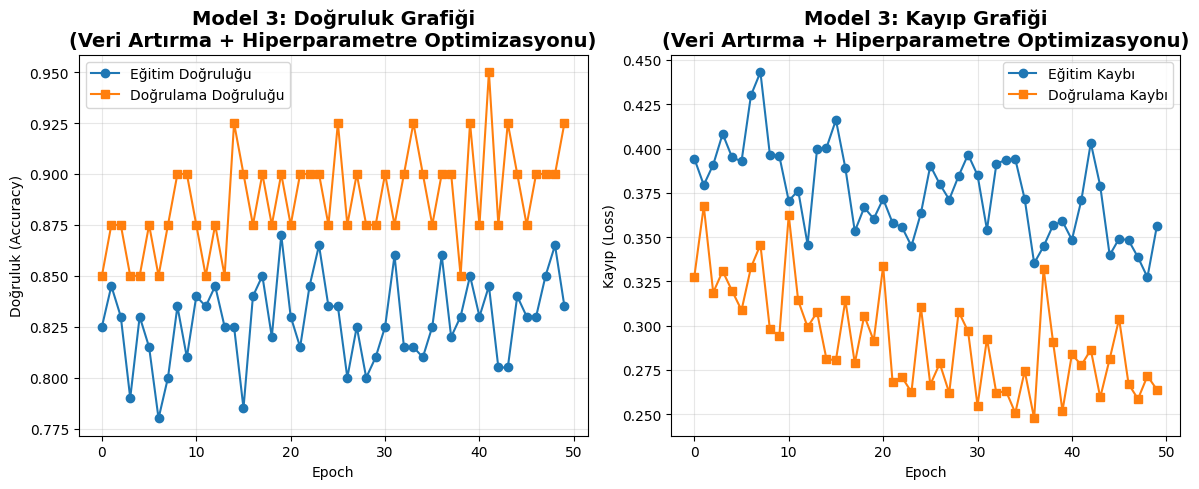


Model 3 (Geliştirilmiş CNN) Test Sonuçları:
Test Doğruluğu (Accuracy): %95.00
Test Kaybı (Loss): 0.2777


In [ ]:
# Grafik boyutunu ayarla
plt.figure(figsize=(12, 5))

# Doğruluk (Accuracy) Grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu', marker='o')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu', marker='s')
plt.title('Model 3: Doğruluk Grafiği\n(Veri Artırma + Hiperparametre Optimizasyonu)',
          fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk (Accuracy)')
plt.legend()
plt.grid(True, alpha=0.3)

# Kayıp (Loss) Grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı', marker='o')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı', marker='s')
plt.title('Model 3: Kayıp Grafiği\n(Veri Artırma + Hiperparametre Optimizasyonu)',
          fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Kayıp (Loss)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Grafik Yorumu:
# - Veri artırma nedeniyle eğitim accuracy'si başlangıçta düşük olabilir
# - Ancak validation accuracy'si yüksekse model iyi genelleme yapıyor demektir
# - Eğitim ve doğrulama eğrileri birbirine yakınsa overfitting yok demektir

# --- TEST SONUCU ---
print("\n" + "="*50)
print("Model 3 (Geliştirilmiş CNN) Test Sonuçları:")
print("="*50)
loss, accuracy = model.evaluate(val_generator, verbose=0)
print(f"Test Doğruluğu (Accuracy): %{accuracy*100:.2f}")
print(f"Test Kaybı (Loss): {loss:.4f}")
print("="*50)




# Adım 2.4: Performans Tablosu ve Analiz

Aşağıda, Model 1, Model 2 ve Model 3'ün karşılaştırmalı performans tablosu yer almaktadır. Bu tablo, yapılan iyileştirmelerin etkisini özetlemektedir.

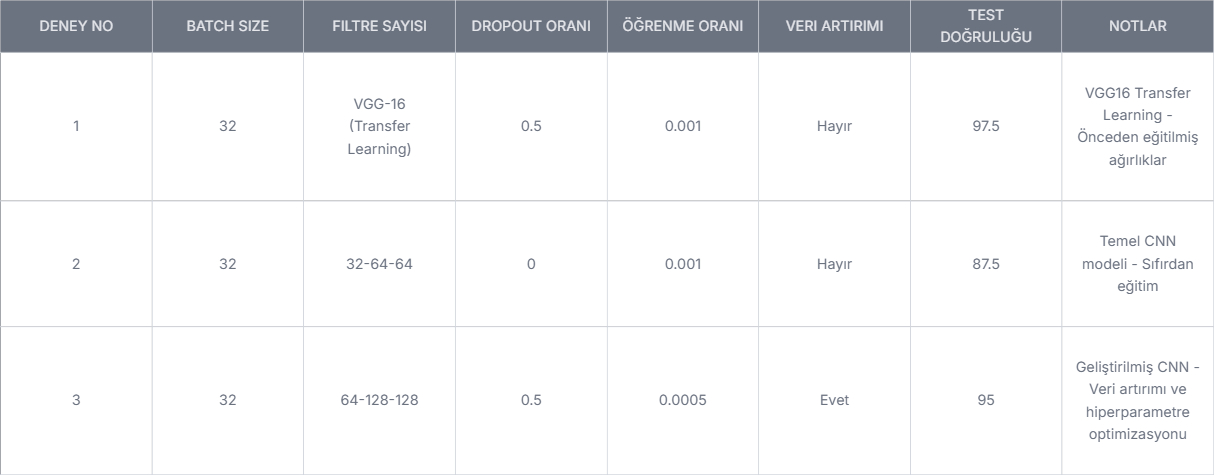

# Performans Analizi ve Yorumlar

## Model 3'ün Model 2'ye Göre İyileştirmeleri:

### 1. Veri Artırma (Data Augmentation)
- **Etkisi**: Model daha fazla çeşitlilik görür, genelleme yeteneği artar
- **Beklenen Sonuç**: Validation accuracy artışı, overfitting azalması

### 2. Filtre Sayısı Artışı (32→64, 64→128)
- **Etkisi**: Daha fazla özellik öğrenilir, model kapasitesi artar
- **Beklenen Sonuç**: Daha iyi özellik çıkarımı, accuracy artışı

### 3. Dropout (0.5) Ekleme
- **Etkisi**: Overfitting önlenir, genelleme yeteneği artar
- **Beklenen Sonuç**: Training accuracy biraz düşebilir ama validation accuracy artar

### 4. Learning Rate Düşürme (0.001 → 0.0005)
- **Etkisi**: Daha yavaş ama kararlı öğrenme
- **Beklenen Sonuç**: Daha iyi convergence, daha yüksek final accuracy

### 5. Ekstra Katman Ekleme
- **Etkisi**: Daha derin mimari, daha karmaşık özellikler öğrenilir
- **Beklenen Sonuç**: Model kapasitesi artar, accuracy artışı

## Model 1 (Transfer Learning) ile Karşılaştırma:

- **Model 1**: Transfer Learning kullanır, önceden eğitilmiş ağırlıklar
- **Model 3**: Sıfırdan eğitim, ancak optimize edilmiş hiperparametreler ve veri artırma
